In [10]:
## import dlc h5 (after running PER_from_DLC-filtered_analysis.ipynb)
#import h5 with light peaks from voltage and/or ROI
#use calculated framerate and peaks times to generate psth

## rewriting scipy peaks with a library


# import stuff
import peaks #my library

import numpy as np
from matplotlib import pyplot as plt
from pprint import pprint
import os
os.listdir(os.getcwd())
import csv as csv
import json as json
import scipy as scipy
from scipy.signal import find_peaks
import h5py


##### get paths ##########
date = '20230505'
fly_id_date_code = f'b-{date[-4:]}' ##'b-0407'
fly_number = 1

####   mostly static variables  ########
data_reducer = 100
voltage_framerate = 10000/data_reducer #frames/s # 1frame/.1ms * 1000ms/1s = 10000f/s
#with reducer i get 1 frame for every .1 * 100 ms => frame/.1*100 ms * 1000ms/s = 100f/s
#each "frame" is 0.1ms
#video_framerate = 200 #f/s
video_framerate = 38.067 #for flies before 7-7-23 
#video_framerate_downstairs = 33


## now trying to save everything locally

local_path = f"C:/Users/ashsm/Documents/Stanford/bruker behavior/{date}"
SavePath = local_path + 'h5_files/'
peaks.make_dirs(SavePath)







### not local paths



#Path = 'G:/bruker vid 2023/20230407/results/'  #path to results files from read ROIs or DLC
# #Path = f'E:/bruker_vid_2023/{date}/results/'  #path to results files from read ROIs or DLC
# Path = f'H:/{date}/results/'  #path to results files from read ROIs or DLC



# SavePath = Path + 'h5_files/'
# peaks.make_dirs(SavePath)



####   mostly static variables  ########
data_reducer = 100
voltage_framerate = 10000/data_reducer #frames/s # 1frame/.1ms * 1000ms/1s = 10000f/s
#with reducer i get 1 frame for every .1 * 100 ms => frame/.1*100 ms * 1000ms/s = 100f/s
#each "frame" is 0.1ms
#video_framerate = 200 #f/s
video_framerate = 38.067 #for flies before 7-7-23 
#video_framerate_downstairs = 33


h5files = [file for file in os.listdir(SavePath) if '.h5' in file]
print('not dlc', h5files)
dlc_h5_file = f"C:/Users/ashsm/Documents/Stanford/bruker behavior/h5files_dlc/{date}_fly{fly_number}_dlc.h5"
roi_h5 = f'{date}_fly_number_{fly_number}_.h5'
roi_h5_file = os.path.join(SavePath, roi_h5)
print(roi_h5_file)

voltage_path = f"C:/Users/ashsm/Documents/Stanford/bruker behavior/voltage/{date}/"
light_peaks_h5 = f'light_peaks_fly{fly_number}.h5'
#light_peaks_h5 = f'fly{fly_number}_light_peaks.h5'
#light_peaks_h5 = f'light_peaks.h5'
light_peaks_file = os.path.join(voltage_path, light_peaks_h5)
# voltage_file = "C:/Users/ashsm/Documents/Stanford/bruker behavior/voltage/20230616/fly2_func-001_Cycle00001_VoltageRecording_001.csv"

not dlc ['20230505_fly_number_1_.h5', '20230505_fly_number_2_.h5']
C:/Users/ashsm/Documents/Stanford/bruker behavior/20230505h5_files/20230505_fly_number_1_.h5


In [8]:
print(dlc_h5_file)
print(roi_h5_file)
print(light_peaks_file)

C:/Users/ashsm/Documents/Stanford/bruker behavior/h5files_dlc/20230505_fly1_dlc.h5
C:/Users/ashsm/Documents/Stanford/bruker behavior/20230505h5_files/20230505_fly_number_1_.h5
C:/Users/ashsm/Documents/Stanford/bruker behavior/voltage/20230505/light_peaks_fly1.h5


In [11]:
##open files and see which keys I want
current_file = light_peaks_file
with h5py.File(current_file, 'a') as f:
    print(f.keys())
    

#dlc file = 'median and std filtered DLC peaks'
#roi file = 'calculated framerate', 'threshold light on'
# light peaks = 'light peaks ms'

with h5py.File(light_peaks_file, 'a') as f:
    print(f.keys())
    voltage_peaks_ms = f['light peaks ms'][()]

with h5py.File(roi_h5_file, 'a') as f:
    print(f.keys())
    framerate = f['calculated framerate'][()]
    threshold_roi_light = f['threshold light on'][()]

with h5py.File(dlc_h5_file, 'a') as f:
    print(f.keys())
    dlc_PER = f['median and std filtered DLC peaks'][()]

<KeysViewHDF5 ['light peaks ms']>
<KeysViewHDF5 ['light peaks ms']>
<KeysViewHDF5 ['PER peaks', 'PER peaks sec', 'calculated framerate', 'fly-id', 'light peaks', 'light peaks sec', 'raw light', 'roi data', 'roi peak left bases', 'threshold light on']>
<KeysViewHDF5 ['DLC peaks unfiltered', 'difference', 'extend_likelihood', 'extend_x', 'extend_y', 'extension difference', 'head_likelihood', 'head_x', 'head_y', 'median and std filtered DLC peaks', 'median filtered DLC peaks', 'neck difference', 'neck_likelihood', 'neck_x', 'neck_y', 'proboscis_likelihood', 'proboscis_x', 'proboscis_y']>


In [22]:
#get dlc_PER into s

print(dlc_PER)
print(framerate)
new_framerate = 37.87719110668233

#new_framerate = new_fr

dlc_PER_s = dlc_PER/new_framerate

roi_light_s = threshold_roi_light/new_framerate


# PSTH
light_s = voltage_peaks_ms/1000

light_to_PER_time = []
for p in dlc_PER_s:
    light_to_PER_time = np.asarray([p-light_s[light_s <=p][-1] for p in dlc_PER_s if p > light_s[0] and (p+1) not in light_s ])


PER_before_light = np.asarray([p for p in dlc_PER_s if p < light_s[0]])
print(PER_before_light)


##need to get switch points to seperate into 20s and 40s blocks
difference = 15
#find times between light flashes
light_times = light_s[1:]- light_s[0:-1] 
#check that light peaks is single light peaks 
if len(np.where(light_times < difference)[0]):
    #light_peaks is taking more than one datapoint per peak
    raise Exception(f'WARNING: these are not single peaks check indices {np.where(light_times<15)[0]}')

#find switch points
light_times_diff = np.rint(abs(light_times[1:] - light_times[0:-1]))
switch_ind = np.where(light_times_diff > 15)[0] + 1
print(switch_ind)

# switch_start_stop = peaks.get_switch_start_stop_indices(voltage_path, exp_length1 = 20, exp_length2 = 40)
# print(switch_start_stop)

light_to_PER_time_20 = []
light_to_PER_time_40 = []
for p in dlc_PER_s:
    light_to_PER_time_20_1 = np.asarray([p-light_s[light_s <=p][-1] for p in dlc_PER_s if p > light_s[0] and (p+1) not in light_s and p < light_s[switch_ind[0]] ])
for p in dlc_PER_s:
    light_to_PER_time_20_2 = np.asarray([p-light_s[light_s <=p][-1] for p in dlc_PER_s if p > light_s[switch_ind[1]] and (p+1) not in light_s and p < light_s[switch_ind[2]] ])
for p in dlc_PER_s:
    light_to_PER_time_20_3 = np.asarray([p-light_s[light_s <=p][-1] for p in dlc_PER_s if p > light_s[switch_ind[3]] and (p+1) not in light_s and p < light_s[switch_ind[4]] ])
for p in dlc_PER_s:
    light_to_PER_time_40_1 = np.asarray([p-light_s[light_s <=p][-1] for p in dlc_PER_s if p > light_s[switch_ind[0]] and (p+1) not in light_s and p < light_s[switch_ind[1]] ])
for p in dlc_PER_s:
    light_to_PER_time_40_2 = np.asarray([p-light_s[light_s <=p][-1] for p in dlc_PER_s if p > light_s[switch_ind[2]] and (p+1) not in light_s and p < light_s[switch_ind[3]] ])

light_to_PER_time_20.extend(light_to_PER_time_20_1)
light_to_PER_time_20.extend(light_to_PER_time_20_2)
light_to_PER_time_20.extend(light_to_PER_time_20_3)
light_to_PER_time_40.extend(light_to_PER_time_40_1)
light_to_PER_time_40.extend(light_to_PER_time_40_2)

[    74    172    272    351    434    581    686    775    856    946
   1062   1102   1166   1381   1463   1550   1723   2140   2248   2411
   2481   2589   2789   3428   3635   3787   4102   4184   4440   4625
   4731   5031   5205   5745   5840   5977   5995   6209   6393   6494
   6795   7340   7429   8012   8243   8542   8681   8901   9533   9917
   9953  10021  10148  10307  10435  10571  10691  10789  10975  11082
  11085  11218  11276  11556  11660  11897  11965  12004  12052  12098
  12131  12196  12200  12255  12302  12359  12403  12443  12477  12518
  12563  12619  12658  12701  12730  12754  12803  12865  12905  12936
  13014  13157  13178  13299  13767  13930  14110  14157  14352  14505
  14541  14739  14927  15059  15492  15532  15614  15646  16138  16401
  16512  16838  16918  16968  17046  17078  17282  17301  17375  17593
  17621  17826  17924  17952  18134  18540  18578  19380  19427  19619
  19640  19761  19780  19833  20126  20313  20411  20430  20441  20654
  2103

In [13]:
print(light_s[switch_ind[4]])
print(light_s)
print(light_times_diff[switch_ind])
print(light_times_diff)
print('here',light_s[switch_ind])
print(len(light_s))
print(len(light_times_diff))
print(len(light_times[1:] - light_times[0:-1]))
print(light_times[switch_ind])

2979.0365990125333
[ 168.08744157  188.18594452  208.29393929  228.40403226  248.50653177
  268.61182886  288.71762553  308.82022495  328.93291569  349.04061072
  369.14071229  389.24870706  409.3564021   429.46070005  449.57019354
  469.68078608  489.78618309  509.88938199  529.99627772  550.10397275
  570.21156787  610.3247459   650.43992221  690.55220102  730.66507931
  770.77985597  810.89203486  851.00870988  891.12188791  931.23576534
  971.35064191 1011.46312055 1051.57529944 1091.68987627 1131.80205516
 1171.91922975 1212.03140865 1252.14818358 1292.25686548 1332.36914429
 1372.48202258 1392.59001736 1412.70700439 1432.80650648 1452.91380185
 1473.01809981 1493.12489562 1513.23478876 1533.34188431 1553.44368442
 1573.55517618 1593.66027345 1613.76756883 1633.87936034 1653.98255924
 1674.09305187 1694.19175464 1714.30484503 1734.405646   1754.51713776
 1774.62013684 1814.7342141  1854.84949032 1894.97186044 1935.07384811
 1975.18922425 2015.300404   2055.41488091 2095.53165585 2

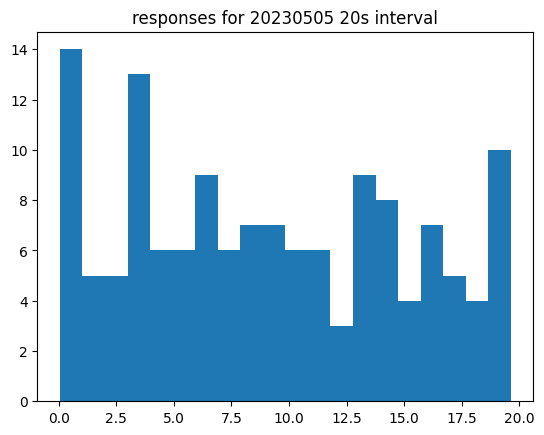

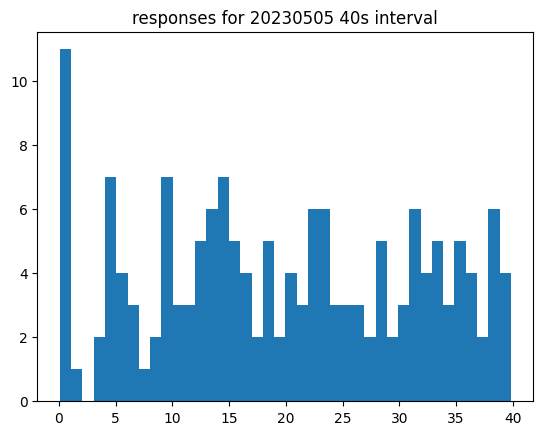

In [23]:
plt.hist(light_to_PER_time_20, bins = 20)
plt.title(f'responses for {date} 20s interval')
#### note!!!! i think there is a start/stop index issue here. check inclusive/exclusive etc.  fixed!
#### CHECK THAT SWITCH IND FOR ZSCORE WORKS CORRECTLY AND DOESN"T CHAnge IDNEX POORLY!!

plt.show()

plt.hist(light_to_PER_time_40, bins = 40)
plt.title(f'responses for {date} 40s interval')
plt.show()

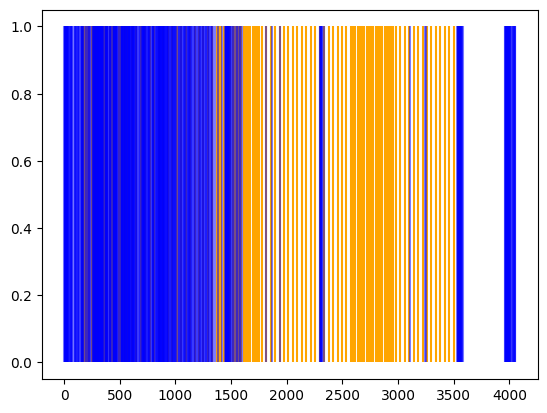

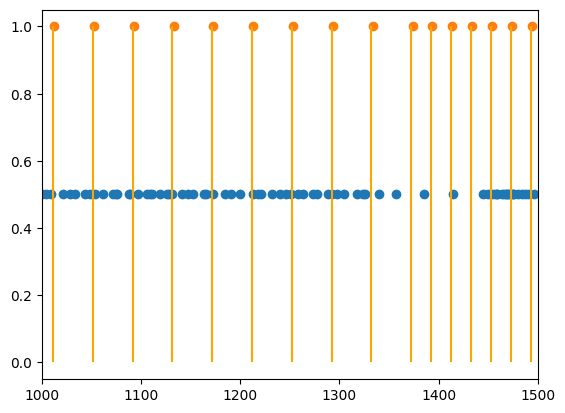

In [15]:
# plt.scatter(light_s, np.ones(len(light_s)))
# plt.scatter(dlc_PER_s, np.ones(len(dlc_PER_s))*2)
plt.vlines(light_s, 0,1,color = 'orange')
plt.vlines(dlc_PER_s, 0,1, color = 'blue', alpha = .5)
plt.show()

plt.vlines(light_s, 0,1,color = 'orange')
#plt.vlines(dlc_PER_s, 0,1, color = 'blue', alpha = .5)
plt.scatter(dlc_PER_s, np.ones(len(dlc_PER_s))*.5)
plt.scatter(roi_light_s, np.ones(len(roi_light_s)))
#plt.scatter(threshold_roi_light, np.ones(len(threshold_roi_light)))

plt.xlim(1000,1500)
plt.show()


[168.30709495 188.424743   208.54239106 228.68644023 248.80408828
 268.92173634 289.03938439 309.18343356 329.30108162 349.41872967]
[168.08744157 188.18594452 208.29393929 228.40403226 248.50653177
 268.61182886 288.71762553 308.82022495 328.93291569 349.04061072]
148
[-0.21965338 -0.23879849 -0.24845177 -0.28240796 -0.29755651 -0.30990747
 -0.32175886 -0.36320861 -0.36816593 -0.37811895 -0.42206655 -0.43171983
 -0.44167285 -0.45502295 -0.48957863 -0.49663415 -0.50888519 -0.54973546
 -0.56048779 -0.57044081 -0.58049375 -0.62340849 -0.66432495 -0.70813891
 -0.72495228 -0.76626839 -0.81018227 -0.84960002 -0.89251476 -0.90832899
 -0.94954519 -0.99315933 -1.03707321 -1.05218804 -1.09610192 -1.1350201
 -1.17893397 -1.1918507  -1.23926157 -1.28307553]
[20.11764806 20.11764806 20.14404917 20.11764806 20.11764806 20.11764806
 20.14404917 20.11764806 20.11764806 20.14404917 20.11764806 20.11764806
 20.11764806 20.14404917 20.11764806 20.11764806 20.14404917 20.11764806
 20.11764806 20.11764806

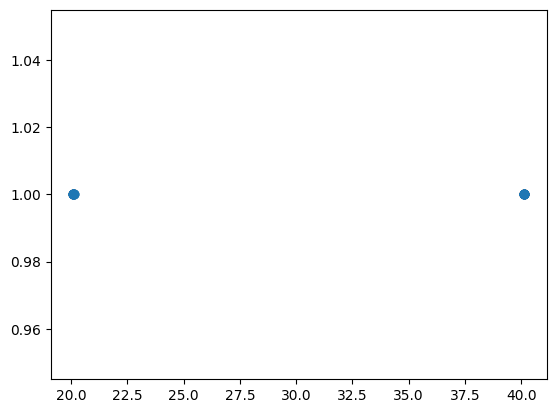

In [20]:
print(roi_light_s[0:10])
print(light_s[0:10])
print(len(roi_light_s))
#print(light_s[0:37] - roi_light_s)
print(light_s[0:40] - roi_light_s[0:40])


diff = (light_s[1:] - light_s[0:-1])
plt.scatter(diff, np.ones(len(diff)), alpha = .2)
print(roi_light_s[1:] - roi_light_s[0:-1])
roi_diff = threshold_roi_light[1:] - threshold_roi_light[0:-1]
print(roi_diff)

light_20 = np.mean(diff[diff < 25])
print(light_20)
fr_20 = np.mean(roi_diff[roi_diff<1000])
new_fr = fr_20/light_20
print(new_fr)

[6.94873409e-01 3.36138582e+00 1.13081208e+01 5.59822441e+00
 7.94792346e+00 3.23177753e+00 9.33043462e+00 1.72243674e+01
 7.84029110e-01 6.59227396e+00 3.17527782e+00 1.33133052e+01
 1.42637453e+01 1.60590209e+01 1.94119623e+01 3.50444214e+00
 6.88378459e+00 1.04743360e+01 1.36424695e+01 1.62297786e+01
 1.03458891e+00 3.85950799e+00 3.93871133e+00 7.45005935e+00
 8.98132390e+00 1.63736355e+01 1.91193513e+01 5.27381562e+00
 7.06909129e+00 8.09873470e+00 9.36598812e+00 1.05804393e+01
 1.14516760e+01 1.31677484e+01 1.32733528e+01 1.47254140e+01
 1.59662664e+01 1.74711298e+01 1.86327788e+01 1.96888233e+01
 4.73770382e-01 1.55621601e+00 2.74426609e+00 4.22272842e+00
 5.25237182e+00 6.38761968e+00 7.15325195e+00 7.78687866e+00
 9.08053320e+00 1.07174022e+01 1.17734467e+01 1.25918812e+01
 1.46511680e+01 1.84265272e+01 1.89809505e+01 2.06779018e+00
 1.44235110e+01 1.87268924e+01 3.37899120e+00 4.61984351e+00
 9.76806053e+00 1.38074308e+01 1.47578709e+01 1.99852912e+01
 4.84070569e+00 8.325652

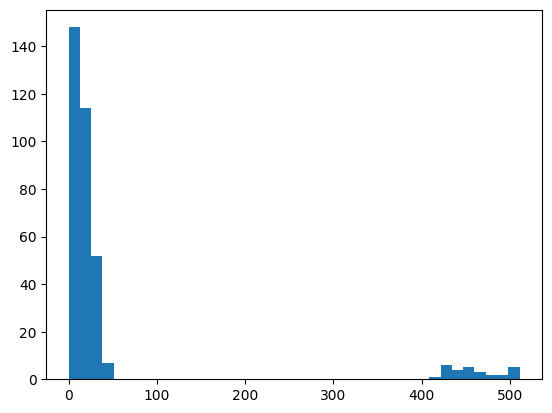

In [21]:
print(light_to_PER_time)
print(voltage_peaks_ms)

plt.hist(light_to_PER_time, bins =40)
plt.show()

In [ ]:
##split by type

In [ ]:
## write code that combines dlc processing,framerate calculation, and psth (with optional runs of each)
combine PER_from_DLC-filtered_analysis
testing_PER_behavior_623
dlc_PSTH



readout should be frames that PER extends or seconds is ok and then I can convert to frames
also light peaks
figure out a way to test if light peaks is corrected